# **Reto 9: Clasificación de géneros musicales a partir de AdaBoost**

Inicialmente, se procede a importar los datos, ejecutar la celda a continuación para descargar el archivo correspondiente y únicamente emplear los géneros *jazz and blues* y *soul and reggae* con el fin de tener un problema de clasificación balanceado.

In [1]:
!wget http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
!unzip msd_genre_dataset.zip
!cat msd_genre_dataset.txt | grep -E 'jazz and blues|soul and reggae' > filter_data.csv

--2019-11-10 13:23:26--  http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
Resolving millionsongdataset.com (millionsongdataset.com)... 173.231.209.32
Connecting to millionsongdataset.com (millionsongdataset.com)|173.231.209.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12656044 (12M) [application/zip]
Saving to: ‘msd_genre_dataset.zip’

msd_genre_dataset.z 100%[===================>]  12.07M  37.6MB/s    in 0.3s    

2019-11-10 13:23:26 (37.6 MB/s) - ‘msd_genre_dataset.zip’ saved [12656044/12656044]

Archive:  msd_genre_dataset.zip
  inflating: msd_genre_dataset.txt   


**Separación y normalización de parámetros:** ejecutar la celda a continuación para aleatorizar las posiciones de los datos, de forma que el entrenamiento no se realice con los mismos datos en todas las ocasiones. Igualmente, se tienen 8350 datos, de los cuales se emplearon 1000 como datos validación, 1000 como datos de prueba y el resto fueron utilizados durante el entrenamiento. Adicionalmente, se realizó un proceso de normalización a partir de un centrado y escalamiento de los datos, esto mediante la resta de la media y la división de este resultado entre la desviación estándar.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

nombres = ['y','ID','Author','Name','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30']
datos = pd.read_csv('filter_data.csv', names = nombres)
datos = datos.reindex(np.random.permutation(datos.index))
data_array = datos.values

#Se ignora el artista, la ID y el nombre de la canción
relevant_data_0 = np.array([np.delete(x, [1,2,3]) for x in data_array])

#Selección de los géneros de interés y conversión a notación binaria (jazz and blues=0, soul and reggae=1)
relevant_data_1 = relevant_data_0
for x in relevant_data_0:
  if x[0] == 'jazz and blues':
    x[0] = 0
  elif x[0] == 'soul and reggae':
    x[0] = 1

relevant_data_1 = (relevant_data_1.astype(np.float))
dataX_raw = relevant_data_1[:,1:]
#Normalización de datos
dataX = ( dataX_raw - np.mean(dataX_raw) ) / np.std(dataX_raw)
dataY = relevant_data_1[:,0]

#Separación de datos de entrenamiento, validación y de prueba
trainX_raw = relevant_data_1[2000:,1:]
trainX = dataX[2000:]
trainY = dataY[2000:]

validationX = dataX[:1000]
validationY = dataY[:1000]

testX = dataX[1000:2000]
testY = dataY[1000:2000]

# Entrenamiento y selección de modelo

Inicialmente, se crea un clasificador con árboles de decisión como clasificadores base, para esto se define el parámetro *base_estimator=None*. Además, el parámetro *n_estimators* corresponde al número máximo de clasificadores empleado (en las diapositivas de clase este parámetro se denota como $T$).

In [0]:
train_ac = []
val_ac = []
max_val_ac = 0
max_val_ac_T = 0
T_min = 1
T_max = 1000

T = range(T_min, T_max)

for i in range(len(T)):
  adaboost_clf = AdaBoostClassifier(base_estimator=None, n_estimators=T[i])
  adaboost_clf.fit(trainX, trainY)

  #print("Número de clasificadores=",T[i])
  prec_val = adaboost_clf.score(validationX,validationY)
  prec_train = adaboost_clf.score(trainX,trainY)
  #print("->Precisión en datos de entrenamiento:", prec_train)
  #print("->Precisión en datos de validación:", prec_val)
  train_ac.append(prec_train)
  val_ac.append(prec_val)
  if prec_val > max_val_ac:
    max_val_ac = prec_val
    adaboost_best_clf = adaboost_clf
    max_val_ac_T = T[i]

-->Mejor clasificador con T= 160 y precisión en datos de prueba: 0.831


Text(0.5, 1.0, 'Entrenamiento de modelo AdaBoost')

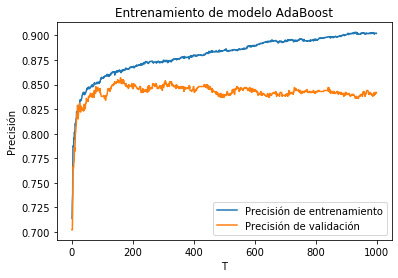

In [50]:
test_ac = adaboost_best_clf.score(testX,testY)
print("-->Mejor clasificador con T=",max_val_ac_T,"y precisión en datos de prueba:", test_ac)

fig, ax = plt.subplots()
ax.plot(T, train_ac, label='Precisión de entrenamiento')
ax.plot(T, val_ac, label='Precisión de validación')
ax.legend()
plt.xlabel("T")
plt.ylabel("Precisión")
plt.title("Entrenamiento de modelo AdaBoost")

**Conclusiones**

-Al realizar una variación del número de clasificadores empleado (T) se observó una relación directa entre la precisión del modelo en los datos de entrenamiento y de validación, ya que no se produjo *overfitting* en ninguno de los casos evaluados (la precisión de validación no se vio reducida significativamente a partir de algún valor de T).

-Sin embargo, se sugiere determinar un valor óptimo de T (en este caso, se podría escoger un valor entre 150 y 200, ya que la precisión de validación no aumenta considerablemente para valores mayores) con el fin de evitar *overfitting* en algún problema distinto al observado en este caso, ya que se tuvo un gran conjunto de datos de entrenamiento en un problema balanceado y de clasificación binaria.

# Referencias

[1] Sklearn AdaBoost Classifier. Disponible en línea en: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

[2] Lozano, Fernando. Clasificadores Combinados. Universidad de los Andes (2019)